In [40]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, when, col, length, regexp_replace
from pyspark.sql.types import IntegerType, BooleanType, StringType
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, PCA
from pyspark.ml.classification import RandomForestClassifier, LinearSVC, GBTClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator
from pyspark.ml import Pipeline

from concurrent.futures import ThreadPoolExecutor

In [41]:
import numpy as np

# Graphics Libs
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 18, 8
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [42]:
spark = SparkSession.builder.appName('URLs_mining').getOrCreate()
spark

In [43]:
# Read the CSV file into a DataFrame
data = spark.read.csv("malicious_urls.csv", header=True, inferSchema=True)

# Show the first few rows of the DataFrame
data.show()

+--------------------+----------+
|                 url|      type|
+--------------------+----------+
|    br-icloud.com.br|  phishing|
|mp3raid.com/music...|    benign|
|bopsecrets.org/re...|    benign|
|http://www.garage...|defacement|
|http://adventure-...|defacement|
|http://buzzfil.ne...|    benign|
|espn.go.com/nba/p...|    benign|
|yourbittorrent.co...|    benign|
|http://www.pashmi...|defacement|
|allmusic.com/albu...|    benign|
|corporationwiki.c...|    benign|
|http://www.ikenmi...|defacement|
|myspace.com/video...|    benign|
|http://www.lebens...|defacement|
|http://www.szabad...|defacement|
|http://larcadelca...|defacement|
|quickfacts.census...|    benign|
|nugget.ca/Article...|    benign|
|uk.linkedin.com/p...|    benign|
|http://www.vnic.c...|defacement|
+--------------------+----------+
only showing top 20 rows



In [44]:
data.groupBy("type").count().show()

+--------------------+------+
|                type| count|
+--------------------+------+
|              benign|428103|
|          defacement| 96457|
|            phishing| 94108|
|             malware| 32520|
|                NULL|    15|
|                Ð|     1|
|PhµW\v;XyOy...|     1|
|cÔ¡æ>1\bHÇÕd...|     1|
|                spam| 12000|
+--------------------+------+



## Data pre-processing

In [45]:
data = data.dropDuplicates(["url"])
data = data.na.drop()

data.groupBy("type").count().show()

+--------------------+------+
|                type| count|
+--------------------+------+
|                spam| 11921|
|              benign|428080|
|          defacement| 95308|
|            phishing| 94083|
|             malware| 23645|
|                Ð|     1|
|PhµW\v;XyOy...|     1|
|cÔ¡æ>1\bHÇÕd...|     1|
+--------------------+------+



In [46]:
data = data.filter(col("type").rlike(r'^[ -~]+$'))
data.groupBy("type").count().show()

+----------+------+
|      type| count|
+----------+------+
|      spam| 11921|
|    benign|428080|
|defacement| 95308|
|  phishing| 94083|
|   malware| 23645|
+----------+------+



In [47]:
# convert spark dataframe to pandas dataframe
pd_data = data.toPandas()

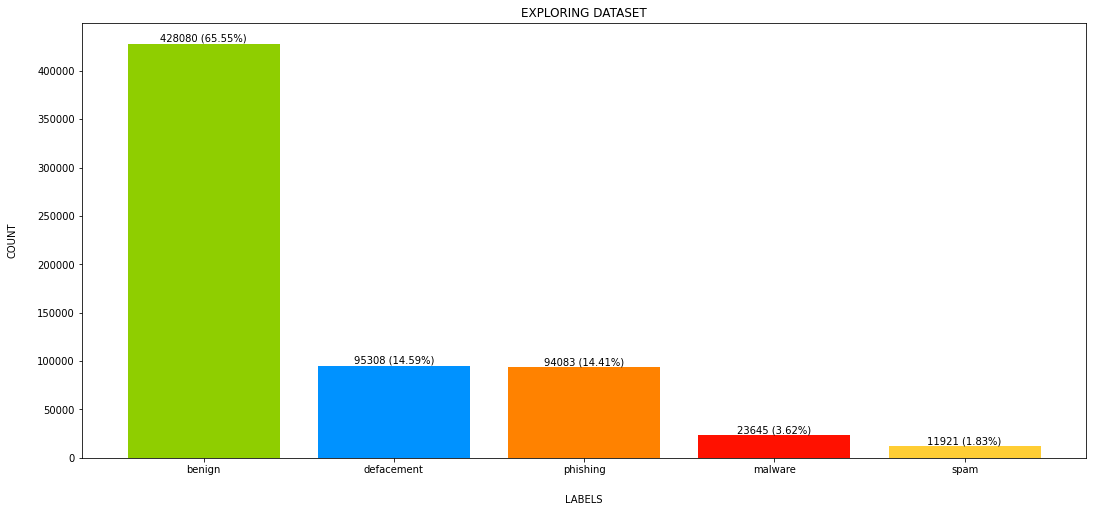

In [48]:
count = pd_data.type.value_counts()
bar_labels = [count.index[i].capitalize()+' (n. ' + str(count[i]) + ')' for i in range(len(count.index))]
bars = plt.bar(count.index, height=count, label=bar_labels, color=['#8fce00', '#0092ff', '#ff8200', '#ff1100', '#ffcd34'])

for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f} ({height/len(pd_data)*100:.2f}%)', ha='center', va='bottom')

plt.xlabel('LABELS', labelpad=20)
plt.ylabel('COUNT', labelpad=20)
plt.title('EXPLORING DATASET')
plt.show()

In [49]:
data = data.withColumn("url_type", when(data["type"].contains("benign"), 0).otherwise(1))
#data = data.drop("type")
data.show()

+--------------------+--------+--------+
|                 url|    type|url_type|
+--------------------+--------+--------+
|   H\vÖË]t¹[ÈöýE|phishing|       1|
|^oð]Â|¬|hõElò...|phishing|       1|
|"½<+U½¹1\f[...|phishing|       1|
|"äÕ3ñºT-\fTÖGÑîÊ...|phishing|       1|
|"ëËl×uÏB'JI¨GÙn"...|phishing|       1|
|'118bm.com/images...|  benign|       0|
|'1pcables-inox.co...|  benign|       0|
|'9d345009-a-62cb3...|  benign|       0|
|'9d345009-a-62cb3...|  benign|       0|
|'9d345009-a-62cb3...|  benign|       0|
|'9d345009-a-62cb3...|  benign|       0|
|'9d345009-a-62cb3...|  benign|       0|
|'9d345009-a-62cb3...|  benign|       0|
|'9d345009-a-62cb3...|  benign|       0|
|'9d345009-a-62cb3...|  benign|       0|
|'9d345009-a-62cb3...|  benign|       0|
|'9d345009-a-62cb3...|  benign|       0|
|'9d345009-a-62cb3...|  benign|       0|
|'9d345009-a-62cb3...|  benign|       0|
|'9d345009-a-62cb3...|  benign|       0|
+--------------------+--------+--------+
only showing top

In [50]:
data = data.filter(col("url").rlike(r'^[ -~]+$'))
data.show()

+--------------------+------+--------+
|                 url|  type|url_type|
+--------------------+------+--------+
|'118bm.com/images...|benign|       0|
|'1pcables-inox.co...|benign|       0|
|'9d345009-a-62cb3...|benign|       0|
|'9d345009-a-62cb3...|benign|       0|
|'9d345009-a-62cb3...|benign|       0|
|'9d345009-a-62cb3...|benign|       0|
|'9d345009-a-62cb3...|benign|       0|
|'9d345009-a-62cb3...|benign|       0|
|'9d345009-a-62cb3...|benign|       0|
|'9d345009-a-62cb3...|benign|       0|
|'9d345009-a-62cb3...|benign|       0|
|'9d345009-a-62cb3...|benign|       0|
|'9d345009-a-62cb3...|benign|       0|
|'9d345009-a-62cb3...|benign|       0|
|'9d345009-a-62cb3...|benign|       0|
|'9d345009-a-62cb3...|benign|       0|
|'9d345009-a-62cb3...|benign|       0|
|'9d345009-a-62cb3...|benign|       0|
|'9d345009-a-62cb3...|benign|       0|
|'9d345009-a-62cb3...|benign|       0|
+--------------------+------+--------+
only showing top 20 rows



In [51]:
data.groupBy("url_type").count().show()

+--------+------+
|url_type| count|
+--------+------+
|       1|224323|
|       0|427801|
+--------+------+



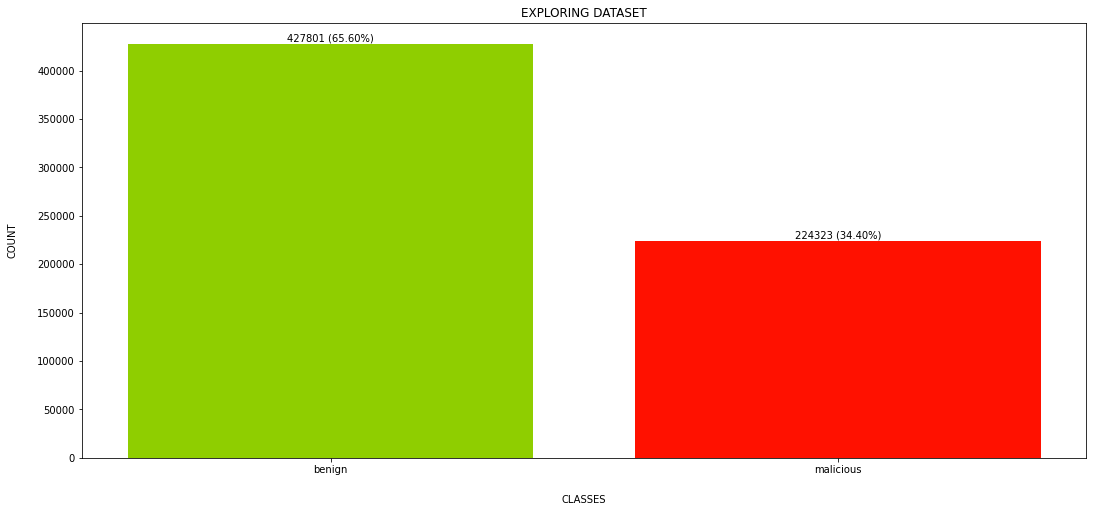

In [52]:
pd_data = data.toPandas()
count = pd_data.type.value_counts()

benign = count[0]
malicious = len(pd_data) - benign
bar_labels = ['Benign (n.'+str(benign)+')', 'Malicious (n.'+str(malicious)+')']
bars = plt.bar(['benign', 'malicious'], height=[benign, malicious], label=bar_labels, color=['#8fce00', '#ff1100'])

for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f} ({height/len(pd_data)*100:.2f}%)', ha='center', va='bottom')

plt.xlabel('CLASSES', labelpad=20)
plt.ylabel('COUNT', labelpad=20)
plt.title('EXPLORING DATASET')
plt.show()

In [53]:
sample_size = 100000

data = data.sampleBy("url_type", fractions={0 : sample_size/data.filter(col("url_type") == 0).count(),
                                               1 : sample_size/data.filter(col("url_type") == 1).count()}, seed=42)
data.groupBy("url_type").count().show()

+--------+------+
|url_type| count|
+--------+------+
|       1|100473|
|       0|100153|
+--------+------+



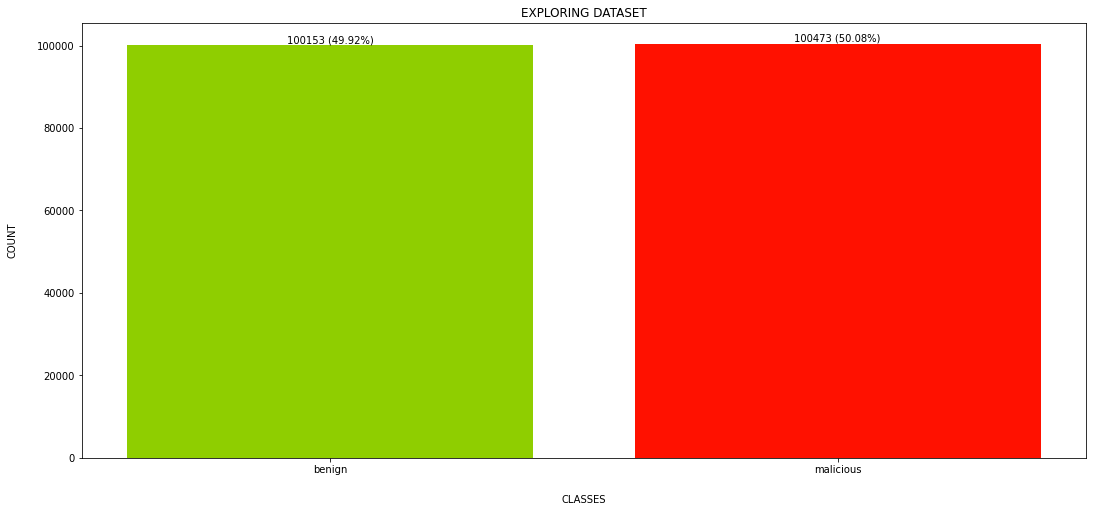

In [54]:
pd_data = data.toPandas()
count = pd_data.type.value_counts()

benign = count[0]
malicious = len(pd_data) - benign
bar_labels = ['Benign (n.'+str(benign)+')', 'Malicious (n.'+str(malicious)+')']
bars = plt.bar(['benign', 'malicious'], height=[benign, malicious], label=bar_labels, color=['#8fce00', '#ff1100'])

for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.0f} ({height/len(pd_data)*100:.2f}%)', ha='center', va='bottom')

plt.xlabel('CLASSES', labelpad=20)
plt.ylabel('COUNT', labelpad=20)
plt.title('EXPLORING DATASET')
plt.show()

## Features engineering

In [55]:
data = data.withColumn("url_length", length("url"))
data = data.withColumn("digit_count", length(regexp_replace(col("url"), "[^0-9]", "")))
data = data.withColumn("ampersand_count", length(regexp_replace(col("url"), "[^&]", "")))
data = data.withColumn("underscore_count", length(regexp_replace(col("url"), "[^_]", "")))
data = data.withColumn("dot_count", length(regexp_replace(col("url"), "[^.]", "")))
data = data.withColumn("percent_count", length(regexp_replace(col("url"), "[^%]", "")))
data = data.withColumn("at_count", length(regexp_replace(col("url"), "[^@]", "")))
data = data.withColumn("tilde_count", length(regexp_replace(col("url"), "[^~]", "")))
data = data.withColumn("hash_count", length(regexp_replace(col("url"), "[^#]", "")))
data = data.withColumn("has_https", when(data["url"].startswith("https"), 1).otherwise(0))
data = data.withColumn("has_http", when(data["url"].startswith("http"), 1).otherwise(0))
data = data.withColumn("starts_with_digit", when(data["url"].rlike("^[0-9]"), 1).otherwise(0))

In [56]:
data.show()

+--------------------+------+--------+----------+-----------+---------------+----------------+---------+-------------+--------+-----------+----------+---------+--------+-----------------+
|                 url|  type|url_type|url_length|digit_count|ampersand_count|underscore_count|dot_count|percent_count|at_count|tilde_count|hash_count|has_https|has_http|starts_with_digit|
+--------------------+------+--------+----------+-----------+---------------+----------------+---------+-------------+--------+-----------+----------+---------+--------+-----------------+
|'9d345009-a-62cb3...|benign|       0|       363|         46|              2|               1|        3|            3|       0|          0|         0|        0|       0|                0|
|'9d345009-a-62cb3...|benign|       0|       371|         51|              2|               6|        3|            3|       0|          0|         0|        0|       0|                0|
|'9d345009-a-62cb3...|benign|       0|       371|         50

### Features selection

In [57]:
data = data.drop("type")
data.columns

['url',
 'url_type',
 'url_length',
 'digit_count',
 'ampersand_count',
 'underscore_count',
 'dot_count',
 'percent_count',
 'at_count',
 'tilde_count',
 'hash_count',
 'has_https',
 'has_http',
 'starts_with_digit']

In [58]:
feature_columns = [
    "url_length",
    "digit_count",
    "ampersand_count",
    "underscore_count",
    "dot_count",
    "percent_count",
    "at_count",
    "tilde_count",
    "hash_count",
    "has_https",
    "has_http",
    "starts_with_digit"
]
len(feature_columns)

12

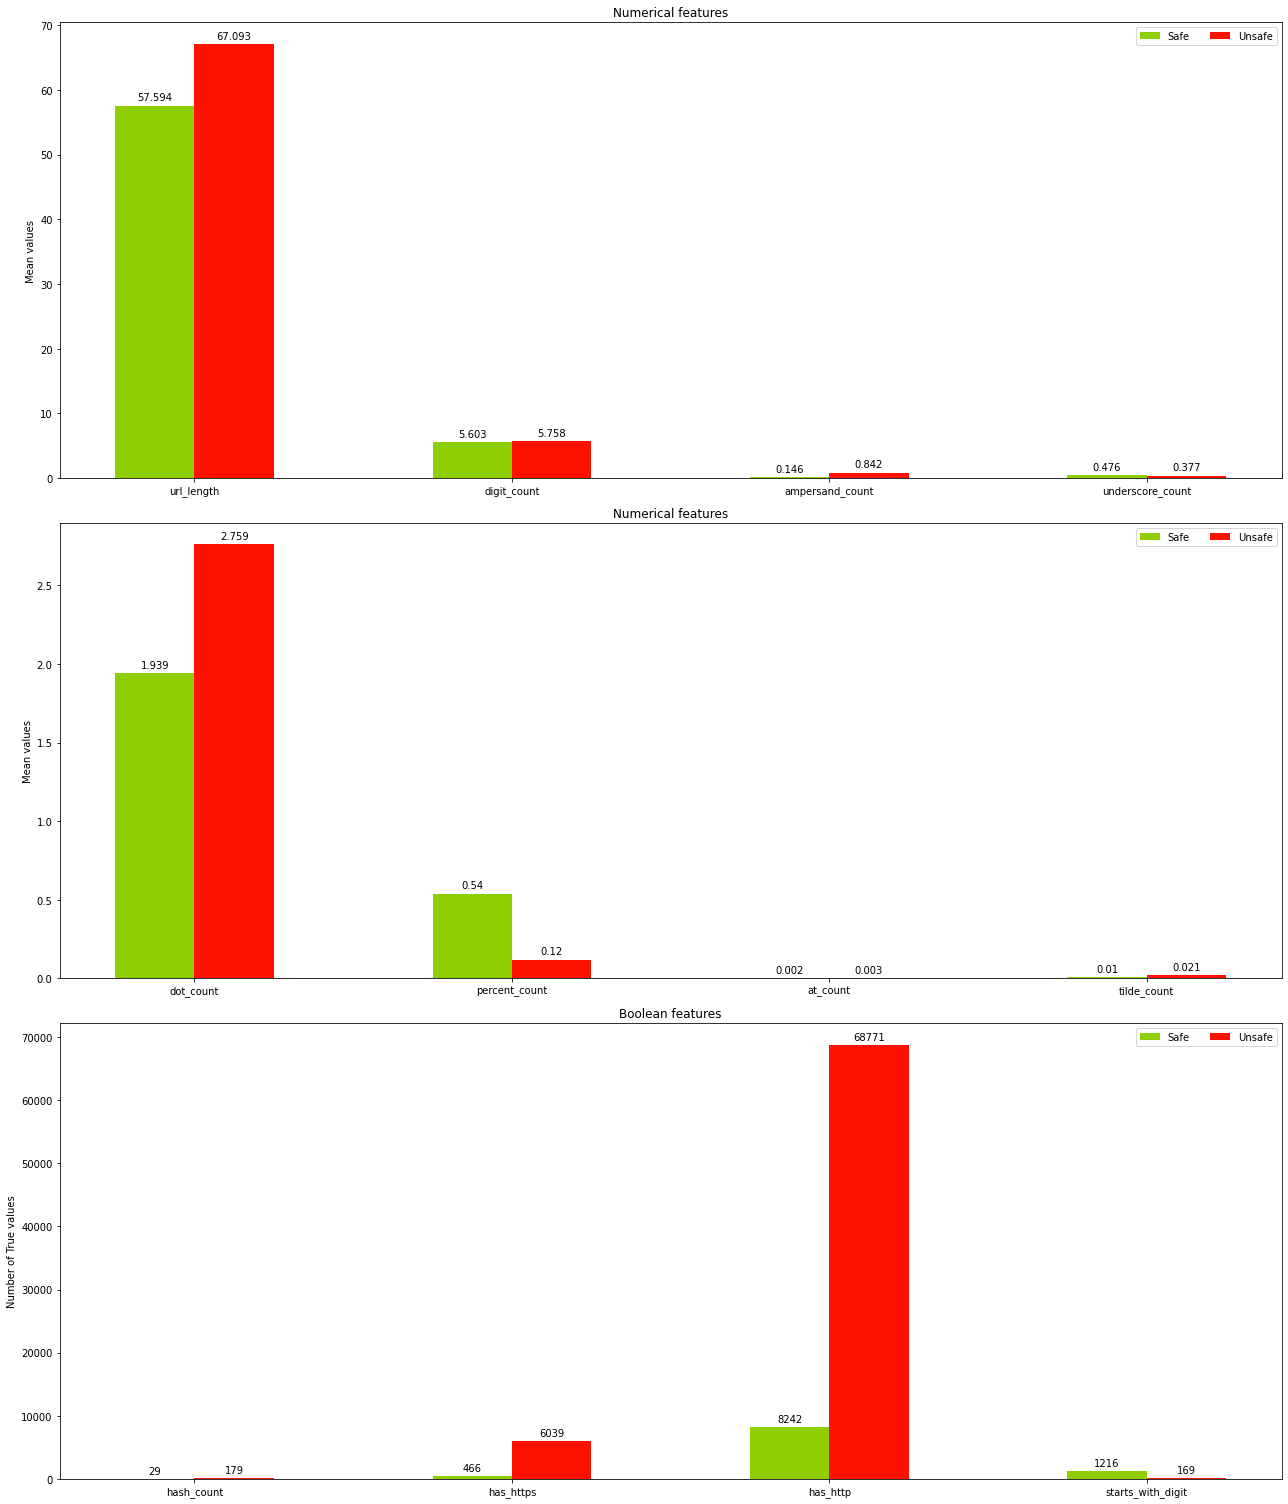

In [59]:
pd_data = data.toPandas()

safe = pd_data[pd_data['url_type'] == 0]
unsafe = pd_data[pd_data['url_type'] == 1]


labels_x1 = ["url_length", "digit_count", "ampersand_count", "underscore_count"]
labels_x2 = ["dot_count", "percent_count", "at_count", "tilde_count"]
labels_x3 = ["hash_count", "has_https", "has_http", "starts_with_digit"]

features_to_plot1 = {'Safe': [], 'Unsafe': []}
features_to_plot2 = {'Safe': [], 'Unsafe': []}
features_to_plot3 = {'Safe': [], 'Unsafe': []}

for i in labels_x1:
    features_to_plot1['Safe'].append(safe.loc[:, i].mean())
    features_to_plot1['Unsafe'].append(unsafe.loc[:, i].mean())

for i in labels_x2:
    features_to_plot2['Safe'].append(safe.loc[:, i].mean())
    features_to_plot2['Unsafe'].append(unsafe.loc[:, i].mean())

for i in labels_x3:
    features_to_plot3['Safe'].append(safe.loc[:, i].sum())
    features_to_plot3['Unsafe'].append(unsafe.loc[:, i].sum())

x1 = np.arange(len(labels_x1))  # the label locations
x2 = np.arange(len(labels_x2))  # the label locations
x3 = np.arange(len(labels_x3))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ((ax1), (ax2), (ax3)) = plt.subplots(3, 1, figsize=(18, 21))

for attribute, measurement in features_to_plot1.items():
    offset = width * multiplier
    rects = ax1.bar(x1 + offset, [round(i,3) for i in measurement], width, label = attribute, color = ['#8fce00' if attribute == 'Safe' else '#ff1100'])
    ax1.bar_label(rects, padding = 3)
    multiplier += 1
ax1.set_ylabel('Mean values')
ax1.set_title('Numerical features')
ax1.set_xticks(x1 + (width/2), labels_x1)
ax1.legend(loc = 'upper right', ncol = 2)

for attribute, measurement in features_to_plot2.items():
    offset = width * multiplier
    rects = ax2.bar(x2 + offset, [round(i,3) for i in measurement], width, label = attribute, color = ['#8fce00' if attribute == 'Safe' else '#ff1100'])
    ax2.bar_label(rects, padding = 3)
    multiplier += 1
ax2.set_ylabel('Mean values')
ax2.set_title('Numerical features')
ax2.set_xticks(x2 + (width*2.5), labels_x2)
ax2.legend(loc = 'upper right', ncol = 2)

for attribute, measurement in features_to_plot3.items():
    offset = width * multiplier
    rects = ax3.bar(x3 + offset, [round(i,3) for i in measurement], width, label = attribute, color = ['#8fce00' if attribute == 'Safe' else '#ff1100'])
    ax3.bar_label(rects, padding = 3)
    multiplier += 1
ax3.set_ylabel('Number of True values')
ax3.set_title('Boolean features')
ax3.set_xticks(x3 + (width*4.5), labels_x3)
ax3.legend(loc = 'upper right', ncol = 2)

plt.tight_layout()
plt.show()

In [60]:
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features_vector")
data = assembler.transform(data)

In [61]:
data.select("features_vector").show(truncate=False)

+-----------------------------------------------+
|features_vector                                |
+-----------------------------------------------+
|(12,[0,1,2,3,4,5],[363.0,46.0,2.0,1.0,3.0,3.0])|
|(12,[0,1,2,3,4,5],[371.0,51.0,2.0,6.0,3.0,3.0])|
|(12,[0,1,2,3,4,5],[371.0,50.0,2.0,2.0,3.0,3.0])|
|(12,[0,1,2,3,4,5],[371.0,55.0,2.0,5.0,3.0,3.0])|
|(12,[0,1,2,3,4,5],[371.0,44.0,2.0,1.0,3.0,3.0])|
|(12,[0,1,2,3,4,5],[371.0,54.0,2.0,1.0,3.0,3.0])|
|(12,[0,1,2,3,4,5],[371.0,46.0,2.0,5.0,3.0,3.0])|
|(12,[0,1,2,3,4,5],[371.0,56.0,2.0,4.0,3.0,3.0])|
|(12,[0,1,2,3,4,5],[371.0,54.0,2.0,3.0,3.0,3.0])|
|(12,[0,1,2,3,4,5],[371.0,51.0,2.0,2.0,3.0,3.0])|
|(12,[0,1,2,3,4,5],[371.0,36.0,2.0,4.0,3.0,3.0])|
|(12,[0,1,2,3,4,5],[371.0,53.0,2.0,1.0,3.0,3.0])|
|(12,[0,1,2,3,4,5],[371.0,50.0,2.0,5.0,3.0,3.0])|
|(12,[0,1,2,3,4,5],[371.0,57.0,2.0,1.0,3.0,3.0])|
|(12,[0,1,2,3,4,5],[371.0,44.0,2.0,7.0,3.0,3.0])|
|(12,[0,1,2,3,4,5],[371.0,50.0,2.0,1.0,3.0,3.0])|
|(12,[0,1,2,3,4,5],[371.0,50.0,2.0,5.0,3.0,3.0])|


#### Min-Max scaling

In [62]:
# Creazione di un oggetto MinMaxScaler
min_max_scaler = MinMaxScaler(inputCol="features_vector", outputCol="scaled_features")

# Creazione di un oggetto Pipeline
min_max_pipeline = Pipeline(stages=[min_max_scaler])

# Addestramento del modello e trasformazione del DataFrame
min_max_model = min_max_pipeline.fit(data)
data = min_max_model.transform(data)

In [63]:
data.select("scaled_features").show(10)

+--------------------+
|     scaled_features|
+--------------------+
|(12,[0,1,2,3,4,5]...|
|(12,[0,1,2,3,4,5]...|
|(12,[0,1,2,3,4,5]...|
|(12,[0,1,2,3,4,5]...|
|(12,[0,1,2,3,4,5]...|
|(12,[0,1,2,3,4,5]...|
|(12,[0,1,2,3,4,5]...|
|(12,[0,1,2,3,4,5]...|
|(12,[0,1,2,3,4,5]...|
|(12,[0,1,2,3,4,5]...|
+--------------------+
only showing top 10 rows



#### Principal Component Analysis - PCA

In [64]:
pca = PCA(k=5, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(data)

In [65]:
data = pca_model.transform(data)

In [66]:
data.select("pca_features").show(truncate=False)

+--------------------------------------------------------------------------------------------------------------+
|pca_features                                                                                                  |
+--------------------------------------------------------------------------------------------------------------+
|[-0.0067109174354255535,-0.00316804819082955,-3.7478004956300427E-4,0.17559904279058972,-0.018358191045913963]|
|[-0.0072790567370971,-0.003970869526189762,-6.09243787391657E-4,0.23742075019371547,-0.0999988020714439]      |
|[-0.006921506686156236,-0.0033462049580184495,-4.1246585543996955E-4,0.19057798885656393,-0.03518672341220894]|
|[-0.007214088748729602,-0.0038002213476157187,-5.466494164500249E-4,0.22661826457071022,-0.08385439957954649] |
|[-0.006799080993394107,-0.0032096321595178542,-3.8140063262471444E-4,0.1776385509717172,-0.018904398160520156]|
|[-0.006856538697788737,-0.0031755567794444052,-3.4987148449833747E-4,0.17977550323355868,-0.019

## Classification models

### Train test split

In [67]:
train, test = data.randomSplit([0.8, 0.2], seed = 2018)

In [68]:
# Funzione per addestrare e valutare un classificatore
def train_and_evaluate(classifier, train, test):
    print(f"Training of: {classifier.__class__.__name__}")

    evaluator = MulticlassClassificationEvaluator(labelCol="url_type", predictionCol="prediction", metricName="accuracy")

    pipeline = Pipeline(stages=[classifier])

    model = pipeline.fit(train)
    predictions = model.transform(test)

    accuracy = round(evaluator.evaluate(predictions), 3)

    evaluator.setMetricName("weightedPrecision")
    precision = round(evaluator.evaluate(predictions), 3)

    evaluator.setMetricName("weightedRecall")
    recall = round(evaluator.evaluate(predictions), 3)

    result = {
        "model": model,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall
    }

    # Stampa le metriche del modello
    print(f"Accuracy of {classifier.__class__.__name__}: {accuracy}")
    print(f"Precision of {classifier.__class__.__name__}: {precision}")
    print(f"Recall of {classifier.__class__.__name__}: {recall}\n")

    return classifier.__class__.__name__, result

### Models trained using scaled features

In [69]:
base_classifiers = [
    RandomForestClassifier(featuresCol='scaled_features', labelCol='url_type'),
    LogisticRegression(featuresCol='scaled_features', labelCol='url_type'),
    LinearSVC(featuresCol='scaled_features', labelCol='url_type'),
    GBTClassifier(featuresCol='scaled_features', labelCol='url_type')
]

base_classifiers_results = {}

In [70]:
with ThreadPoolExecutor() as executor:
    base_classifiers_results = dict(executor.map(lambda clf: train_and_evaluate(clf, train, test), base_classifiers))

Training of: RandomForestClassifier
Training of: LogisticRegression
Training of: LinearSVC
Training of: GBTClassifier
Accuracy of LogisticRegression: 0.796
Precision of LogisticRegression: 0.81
Recall of LogisticRegression: 0.796

Accuracy of RandomForestClassifier: 0.841
Precision of RandomForestClassifier: 0.852
Recall of RandomForestClassifier: 0.841

Accuracy of GBTClassifier: 0.865
Precision of GBTClassifier: 0.867
Recall of GBTClassifier: 0.865

Accuracy of LinearSVC: 0.808
Precision of LinearSVC: 0.823
Recall of LinearSVC: 0.808



In [71]:
base_classifiers_results

{'RandomForestClassifier': {'model': PipelineModel_c449dde0f908,
  'accuracy': 0.841,
  'precision': 0.852,
  'recall': 0.841},
 'LogisticRegression': {'model': PipelineModel_3047f97ee663,
  'accuracy': 0.796,
  'precision': 0.81,
  'recall': 0.796},
 'LinearSVC': {'model': PipelineModel_9b38b2810a00,
  'accuracy': 0.808,
  'precision': 0.823,
  'recall': 0.808},
 'GBTClassifier': {'model': PipelineModel_1d56ec4bdc5f,
  'accuracy': 0.865,
  'precision': 0.867,
  'recall': 0.865}}

### Models trained using PCA features

In [72]:
pca_classifiers = [
    RandomForestClassifier(featuresCol='pca_features', labelCol='url_type'),
    LogisticRegression(featuresCol='pca_features', labelCol='url_type'),
    LinearSVC(featuresCol='pca_features', labelCol='url_type'),
    GBTClassifier(featuresCol='pca_features', labelCol='url_type')
]

pca_classifiers_results = {}

In [73]:
with ThreadPoolExecutor() as executor:
    pca_classifiers_results = dict(executor.map(lambda clf: train_and_evaluate(clf, train, test), pca_classifiers))

Training of: RandomForestClassifier
Training of: LogisticRegression
Training of: LinearSVC
Training of: GBTClassifier
Accuracy of LogisticRegression: 0.793
Precision of LogisticRegression: 0.808
Recall of LogisticRegression: 0.793

Accuracy of RandomForestClassifier: 0.851
Precision of RandomForestClassifier: 0.852
Recall of RandomForestClassifier: 0.851

Accuracy of GBTClassifier: 0.857
Precision of GBTClassifier: 0.857
Recall of GBTClassifier: 0.857

Accuracy of LinearSVC: 0.8
Precision of LinearSVC: 0.817
Recall of LinearSVC: 0.8



In [74]:
pca_classifiers_results

{'RandomForestClassifier': {'model': PipelineModel_2ee15eb297bb,
  'accuracy': 0.851,
  'precision': 0.852,
  'recall': 0.851},
 'LogisticRegression': {'model': PipelineModel_f0ae5508193b,
  'accuracy': 0.793,
  'precision': 0.808,
  'recall': 0.793},
 'LinearSVC': {'model': PipelineModel_3d805c7e77b4,
  'accuracy': 0.8,
  'precision': 0.817,
  'recall': 0.8},
 'GBTClassifier': {'model': PipelineModel_b56ee9597741,
  'accuracy': 0.857,
  'precision': 0.857,
  'recall': 0.857}}